# Classification of emotions using voice data from RAVDESS dataset
* [Data from RAVDESS dataset](https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio)

### Downloading and saving the data from RAVDESS dataset using Kaggle API

In [139]:
# load the environment variables from the .env file
from dotenv import load_dotenv
import os

load_dotenv()
username = os.environ.get('KAGGLE_USERNAME')
key = os.environ.get('KAGGLE_KEY')

In [140]:
# download the dataset from kaggle
import kaggle
kaggle.api.authenticate()

In [141]:
import zipfile
# check whether the dataset is downloaded or not
kaggle.api.authenticate()
if not os.path.exists('data'):
    # if not, download the dataset
    kaggle.api.dataset_download_files('uwrfkaggler/ravdess-emotional-speech-audio', path='.', unzip=False)
    # unzip the dataset
    with zipfile.ZipFile('ravdess-emotional-speech-audio.zip', 'r') as zip_ref:
            zip_ref.extractall('data')
    # remove the zip file
    os.remove('ravdess-emotional-speech-audio.zip')

In [142]:
import shutil
# delete the the unnecessary directory data\audio_speech_actors_01-24
shutil.rmtree('data/audio_speech_actors_01-24')

### Grouping audio files by emotion they represent

**File naming convention:**
* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).

* Vocal channel (01 = speech, 02 = song).

* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).

* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.

* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").

* Repetition (01 = 1st repetition, 02 = 2nd repetition).

* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

In [143]:
# function to extract the information from the file name
def extract_info(file_name):
    # split the file name
    file_name = file_name.split('-')
    # get the emotion
    emotion = int(file_name[2])
    emotion_dict = {1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fearful', 7:'disgust', 8:'surprised'}
    return emotion_dict[emotion]

In [144]:
# list all files in each subdirectory in data directory
files = []
# for each actors
for actor in os.listdir('data'):
    # for each file in actor directory
    for file in os.listdir(os.path.join('data', actor)):
        files.append(os.path.join('data', actor, file))

In [145]:
import random

# test the function on a random file
file_name = random.choice(files)
print(f'''file path - {file_name}
represented emotion - {extract_info(file_name)}''')

file path - data\Actor_08\03-01-02-01-01-02-08.wav
represented emotion - calm


In [146]:
# we do not need the division due to the actor name
# instead, we will divide the dataset due to the emotion which each file represents

class_names = ['Neutral', 'Calm', 'Happy', 'Sad', 'Angry', 'Fearful', 'Disgust', 'Surprised']

# create a subdirectory for each emotion in data directory
for emotion in class_names:
    if not os.path.exists(os.path.join('data', emotion)):
        os.makedirs(os.path.join('data', emotion), exist_ok=True)

# move the files to the corresponding subdirectory
for file in files:
    if file.endswith('.wav'):
        # get the emotion name from the file name with use of previously defined function
        emotion = extract_info(file)
        # get the file name
        file_name = os.path.basename(file)
        # move the file to the corresponding subdirectory
        shutil.move(file, os.path.join('data', emotion, file_name))

In [147]:
# delete the empty directories whose names are actor names
for actor in os.listdir('data'):
    if actor.startswith('Actor'):
        shutil.rmtree(os.path.join('data', actor))

### Explore the dataset

In [148]:
# plot a barplot to see the number of files in each subdirectory
def plot_emotion_count():
    emotion_count = [len(os.listdir(os.path.join('data', emotion))) for emotion in class_names]
    plt.figure(figsize=(10, 5))
    sns.set_style('darkgrid')
    sns.barplot(x=class_names, y=emotion_count)
    plt.title('Number of files in each subdirectory')
    plt.xlabel('Emotion')
    plt.ylabel('Number of files')
    plt.show()

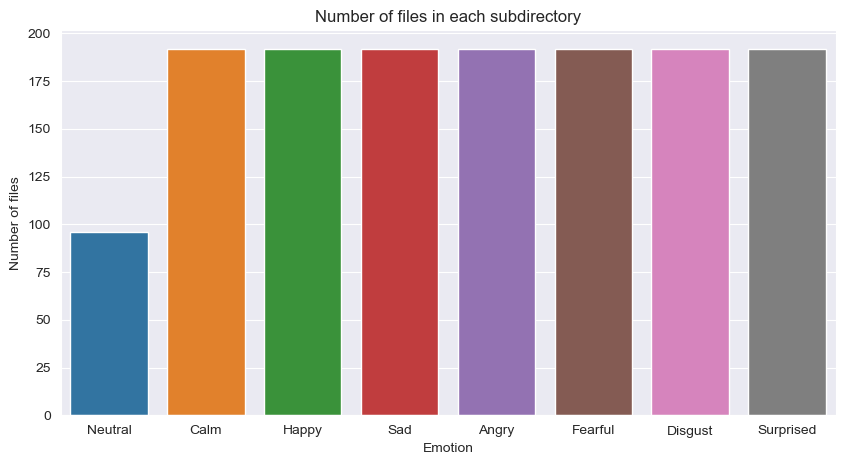

In [149]:
plot_emotion_count()

In [150]:
from librosa import get_duration
# plot the distribution of the time duration of the wav files
def plot_duration_distribution():
    durations = []
    for file in glob.glob('data/*/*.wav'):
        durations.append(get_duration(path=file))
    sns.displot(durations, bins=30, color='green', height=5, aspect=2)
    plt.title('Distribution of the time duration of the wav files')
    plt.xlabel('Time duration (s)')
    plt.ylabel('Count')
    plt.show()

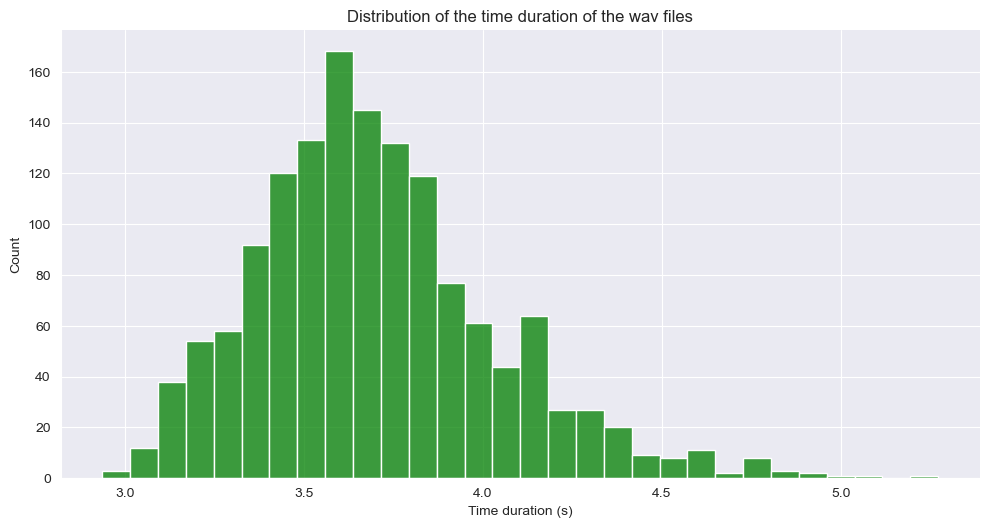

In [151]:
plot_duration_distribution()

In [152]:
# count the number of mono and stereo files
def count_mono_stereo():
    mono = 0
    stereo = 0
    for file in glob.glob('data/*/*.wav'):
        sample, sr = get_sample(file)
        if sample.ndim == 1:
            mono+=1
        else:
            stereo+=1
    return {'mono':mono, 'stereo':stereo}

In [153]:
count_mono_stereo()

{'mono': 1440, 'stereo': 0}

In [156]:
# check the sampling rate of the audio files
def check_sampling_rate():
    sampling_rates = []
    for file in glob.glob('data/*/*.wav'):
        sample, sr = get_sample(file)
        sampling_rates.append(sr)
    sampling_rates = pd.Series(sampling_rates)
    return sampling_rates.value_counts()

In [157]:
check_sampling_rate()

22050    1440
dtype: int64

### Explore the audio files

In [158]:
# get the sample of the audio file
def get_sample(file_name):
    y, sr = librosa.load(file_name)
    # y: audio time series
    # sr: sampling rate of y
    return y, sr

In [159]:
# function to plot the waveplot of the audio file
def plot_waveplot(file_name):
    sample, sr = get_sample(file_name)
    
     # plot the sample
    plt.figure(figsize=(10, 5))
    sns.set_style('darkgrid')
    librosa.display.waveshow(sample, sr=sr)
    emotion = extract_info(file_name)
    noun_emotion = {'neutral':'neutral', 'calm':'calm', 'happy':'happiness',\
                    'sad':'sadness', 'angry':'anger', 'fearful':'fear',\
                    'disgust':'disgust', 'surprised':'surprise'}
    plt.title(f'Emotion: {noun_emotion[emotion]}')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')

In [160]:
# list of files in each subdirectory
files = []
for emotion in class_names:
    for file in os.listdir(os.path.join('data', emotion)):
        files.append(os.path.join('data', emotion, file))

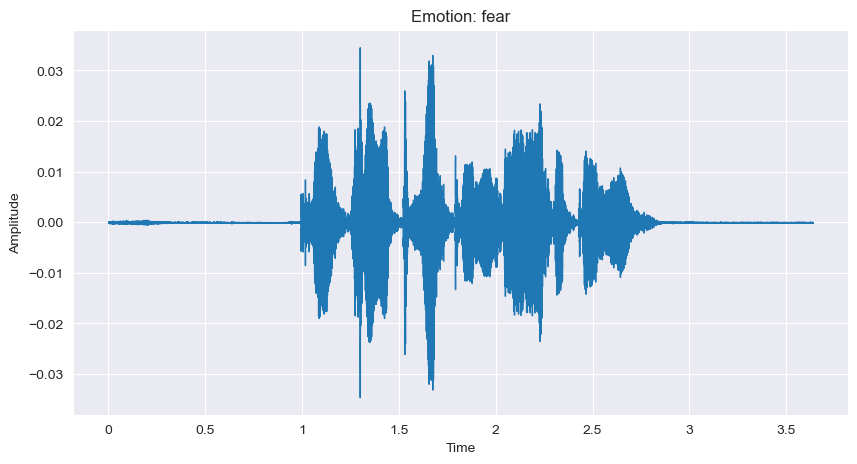

In [161]:
# test the function on a random file
file_name = random.choice(files)
plot_waveplot(file_name)

In [162]:
# function to plot the spectrogram of the audio file
def plot_spectogram(file_name):
    sample, sr = get_sample(file_name)
    # Compute spectrogram
    spec = librosa.feature.melspectrogram(y=sample, sr=sr)

    # Convert power to decibels
    spec_db = librosa.power_to_db(spec, ref=np.max)

    # Plot spectrogram
    fig, ax = plt.subplots(nrows = 1, ncols = 1)
    img = librosa.display.specshow(spec_db, x_axis='time', y_axis='mel', ax = ax)
    fig.colorbar(img, ax = ax, format='%+2.0f dB')
    ax.set_title('Spectrogram')
    plt.show()

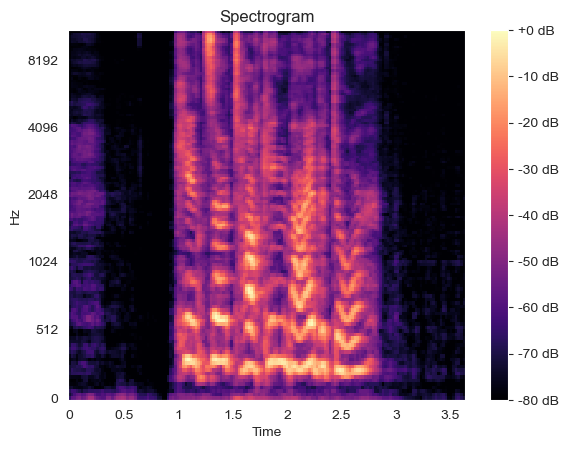

In [163]:
# test the function on previously chosen file
plot_spectogram(file_name)

In [164]:
# function to plot the chromagram of the audio file
def plot_chromagram(file_name):
    sample, sr = get_sample(file_name)
    # Compute chroma energy
    chroma = librosa.feature.chroma_cens(y=sample, sr=sr)

    # Plot chroma energy
    fig, ax = plt.subplots(nrows = 1, ncols = 1)
    img = librosa.display.specshow(chroma, x_axis='time', y_axis='chroma', ax = ax)
    fig.colorbar(img, ax = ax)
    ax.set_title('Chromagram')
    plt.show()

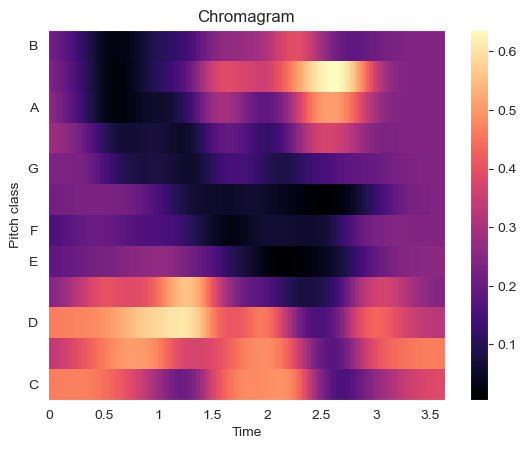

In [165]:
# test the function on previously chosen file
plot_chromagram(file_name)

In [166]:
# function to plot the fast fourier transform of the audio file
def plot_fft(file_name):
    sample, sr = get_sample(file_name)
    fft = np.fft.fft(sample)
    # calculate the magnitude
    magnitude = np.abs(fft)
    # calculate the frequency
    frequency = np.linspace(0, sr, len(magnitude))
    # plot the magnitude
    plt.figure(figsize=(10, 5))
    sns.set_style('darkgrid')
    plt.scatter(frequency, magnitude, s=1)
    plt.title('Discrete Fourier Transform')
    plt.xlabel('Frequency')
    plt.ylabel('Magnitude')
    plt.show()

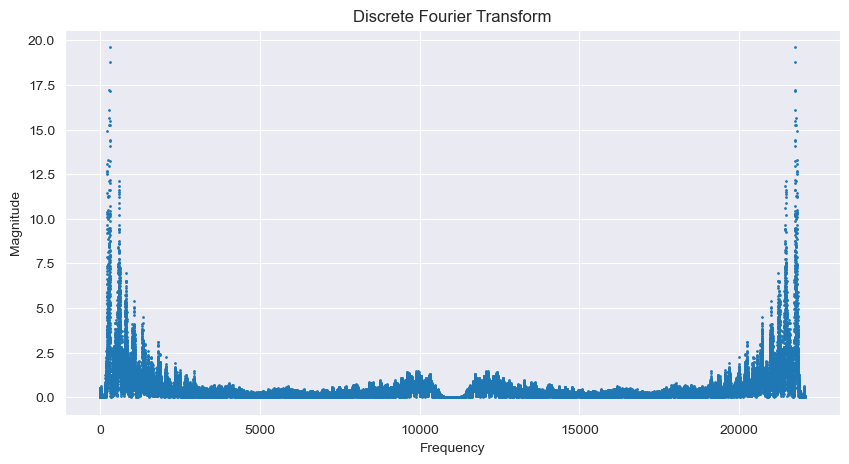

In [167]:
# test the function on previously chosen file
plot_fft(file_name)

In [168]:
# function to plot the mel-frequency cepstral coefficients of the audio file
def plot_mfcc(file_name):
    sample, sr = get_sample(file_name)
    # Compute MFCCs
    mfcc = librosa.feature.mfcc(y=sample, sr=sr)

    # Plot MFCCs
    fig, ax = plt.subplots(nrows = 1, ncols = 1)
    img = librosa.display.specshow(mfcc, x_axis='time', ax = ax)
    fig.colorbar(img, ax = ax)
    ax.set_title('MFCC')
    plt.show()

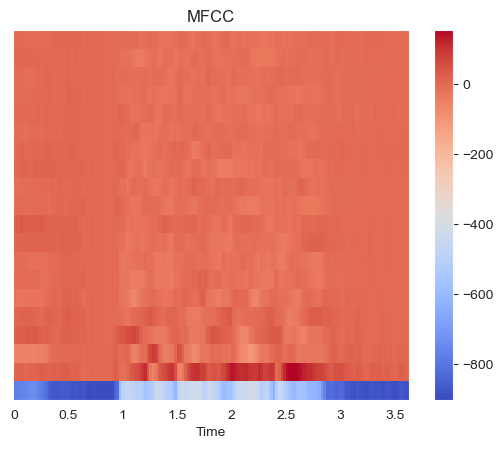

In [169]:
# test the function on previously chosen file
plot_mfcc(file_name)

In [170]:
import IPython.display as ipd
from IPython import display

In [171]:
display.display(ipd.Audio(file_name))
print(f"Emotions: {extract_info(file_name)}")

Emotions: fearful


### Audio data augmentation for preventing overfitting

Data augmentation is a technique used to increase the size of a dataset by adding slightly modified copies of existing data. This is done to prevent overfitting and to improve the generalization of the model. In this project, the following data augmentation techniques are used:

1. **Pitch shifting** - The pitch of the audio is shifted up or down by a random number of semitones. This is done to simulate the effect of a person speaking at a different pitch. The number of semitones is chosen randomly from a uniform distribution between -2 and 3 semitones.

2. **Time stretching** - The audio is stretched or compressed by a random factor. This is done to simulate the effect of a person speaking at a different speed. The factor is chosen randomly from a uniform distribution between 0.8 and 1.2.

3. **Adding noise** - Random noise is added to the audio. This is done to simulate the effect of background noise in a real-world setting. The noise is sampled from a uniform distribution between 0.005 and 0.01.

In [172]:
# add noise to the audio file
def add_noise(sample: np.ndarray, sr:int)->Tuple[np.ndarray, float]:
    noise = np.random.randn(len(sample))
    bias = random.uniform(0.005, 0.01)
    sample = sample + bias * noise
    
    return sample, sr

# change the pitch of the audio file
def pitch_shift(sample: np.ndarray, sr:int)->Tuple[np.ndarray, float]:
    n_steps = random.uniform(-2, 3)
    sample = librosa.effects.pitch_shift(y=sample, sr=sr, n_steps=n_steps)
    return sample, sr

# change the tempo of the audio file
def time_stretch(sample: np.ndarray, sr:int)->Tuple[np.ndarray, float]:
    rate = random.uniform(0.8, 1.2)
    sample = librosa.effects.time_stretch(y=sample, rate=rate)
    return sample, sr

In [173]:
sample, sr = get_sample(file_name)

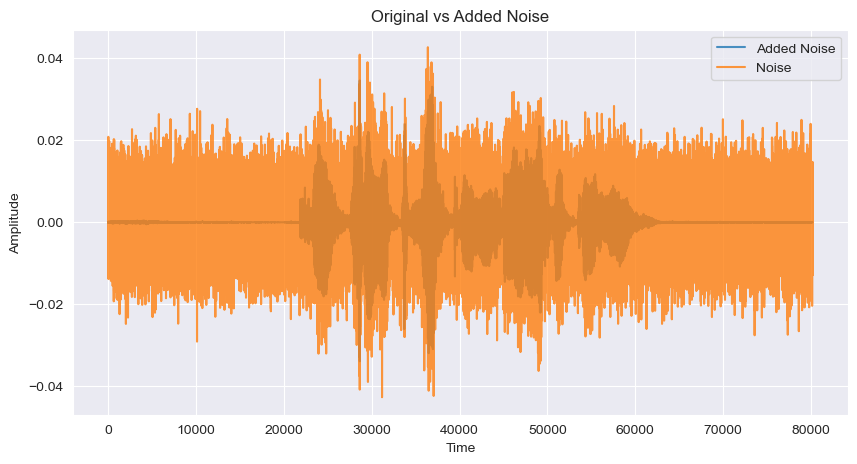

In [175]:
# plot the original audio file and the audio file with added noise
noise_sample, sr = add_noise(sample, sr)
plt.figure(figsize=(10, 5))
sns.set_style('darkgrid')
plt.plot(sample, label='Added Noise', alpha=0.8)
plt.plot(noise_sample, label='Noise', alpha=0.8)
plt.title('Original vs Added Noise')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

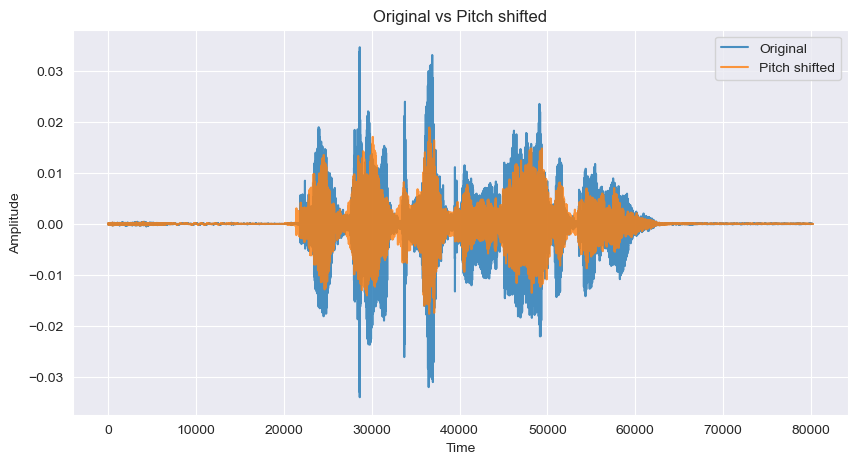

In [176]:
# plot the original audio file and the audio file with shifted pitch
pitch_shifted, sr = pitch_shift(sample, sr)
plt.figure(figsize=(10, 5))
sns.set_style('darkgrid')
plt.plot(sample, label='Original', alpha=0.8)
plt.plot(pitch_shifted, label='Pitch shifted', alpha=0.8)
plt.title('Original vs Pitch shifted')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

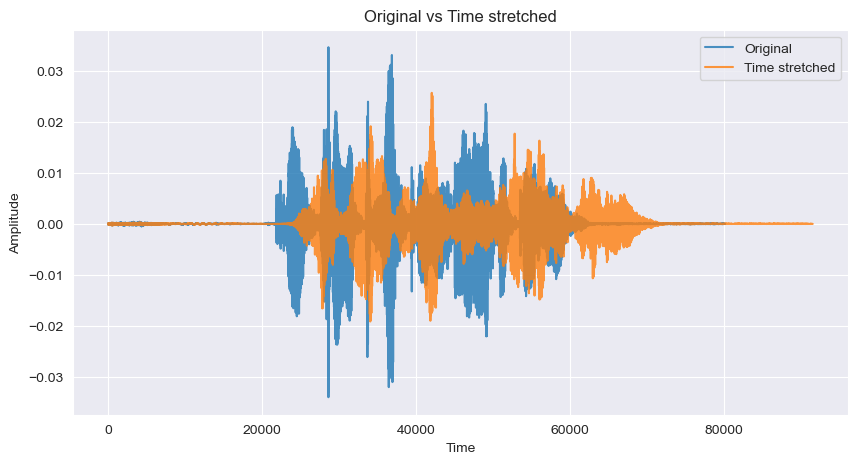

In [178]:
# plot the original and time stretched audio file
time_stretched, sr = time_stretch(sample, sr)
plt.figure(figsize=(10, 5))
sns.set_style('darkgrid')
plt.plot(sample, label='Original', alpha=0.8)
plt.plot(time_stretched, label='Time stretched', alpha=0.8)
plt.title('Original vs Time stretched')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

In [182]:
# play the original, with added noise, pitch shifted and time stretched audio file
print("Original sample:")
display.display(ipd.Audio(sample, rate=sr))
print("Sample with added noise:")
display.display(ipd.Audio(noise_sample, rate=sr))
print("Pitch shifted sample:")
display.display(ipd.Audio(pitch_shifted, rate=sr))
print("Time stretched sample:")
display.display(ipd.Audio(time_stretched, rate=sr))
print(f"Emotion: {extract_info(file_name)}")

Original sample:


Sample with added noise:


Pitch shifted sample:


Time stretched sample:


Emotion: fearful


### Removing silence from the audio files

Function would be called on each audio file to remove the silence from the beginning and end of the audio file. The function would take the audio file as input and return the audio file with the silence removed. The threshold for silence would be set to 20 dBFS.

In [184]:
def remove_silence(sample, sr):
    # remove the noise
    sample = librosa.effects.trim(sample, top_db=20)[0]
    return sample, sr

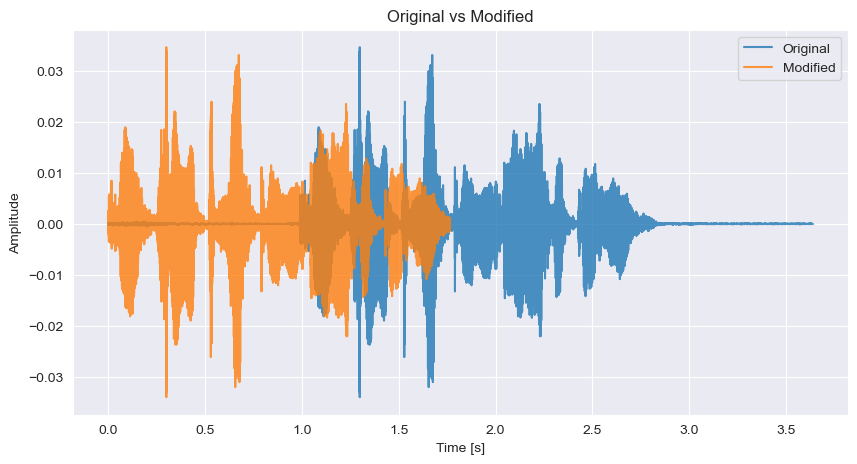

In [185]:
# tets the function
modified_sample, sr = remove_silence(sample, sr)

# plot the original and modified sample
plt.figure(figsize=(10, 5))
sns.set_style('darkgrid')
time_og = np.arange(0, len(sample)) / sr
time_mod = np.arange(0, len(modified_sample)) / sr
plt.plot(time_og, sample,  label='Original', alpha=0.8)
plt.plot(time_mod, modified_sample, label='Modified', alpha=0.8)
plt.title('Original vs Modified')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

In [186]:
# play the original and modified sample
print("Original sample:")
display.display(ipd.Audio(sample, rate=sr))
print("Modified sample:")
display.display(ipd.Audio(modified_sample, rate=sr))

Original sample:


Modified sample:


## Resizing the audio files to a fixed size

The audio files in the dataset have different lengths. In order to use the audio files in a convolutional neural network, the audio files need to be resized to a fixed size.

In [189]:
def pad_trunc_seq(y:np.ndarray, sr:int, max_length:int)->np.ndarray:
    max_length = max_length * sr # max_length in seconds to samples
    if len(y) < max_length:
        y = np.pad(y, (0, max_length - len(y)), 'constant')
    else:
        y = y[:max_length]
    return y, sr

In [190]:
# test the function
# pad the data to 2 seconds
padded_sample, sr = pad_trunc_seq(sample, sr, 2)

# get the duration of the original and padded data using librosa
print("Original sample duration: {}".format(librosa.get_duration(y=sample, sr=sr)))
print("Padded sample duration: {}".format(librosa.get_duration(y=padded_sample, sr=sr)))

# play the original and padded data
print("Original sample:")
display.display(ipd.Audio(sample, rate=sr))
print("Padded sample:")
display.display(ipd.Audio(padded_sample, rate=sr))

Original sample duration: 3.6369614512471657
Padded sample duration: 2.0
Original sample:


Padded sample:


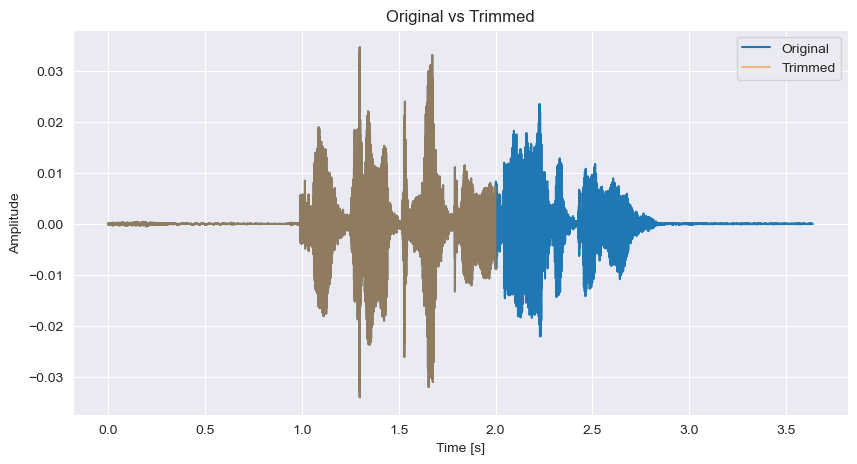

In [191]:
# plot the original and padded data
plt.figure(figsize=(10, 5))
sns.set_style('darkgrid')
time_og = np.arange(0, len(sample)) / sr
time_pad = np.arange(0, len(padded_sample)) / sr
plt.plot(time_og, sample,  label='Original', alpha=1)
plt.plot(time_pad, padded_sample, label='Trimmed', alpha=0.5)
plt.title('Original vs Trimmed')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

### Preprocessing the audio files

The following steps are performed to preprocess the audio files:
* trim the silence from the beginning and end of the audio files,
* resize the audio files to a fixed size,
* augment the audio files,
* extract the spectrogram from the audio files,
* augment the spectrograms.

In [196]:
# create a pipeline to preprocess the data and save it
def preprocess_data(file_name:str, max_length:int=2)->Tuple[np.ndarray, int]:
    sample, sr = get_sample(file_name)
    sample, sr = remove_silence(sample, sr)
    sample, sr = pad_trunc_seq(sample, sr, max_length)
    return sample, sr

def get_spectrogram(sample:np.ndarray, sr:int)->np.ndarray:
    spectrogram = librosa.feature.melspectrogram(y=sample, sr=sr)
    spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    return spectrogram

In [218]:
file_name = random.choice(files)

data\Fearful\03-01-06-01-02-02-19.wav


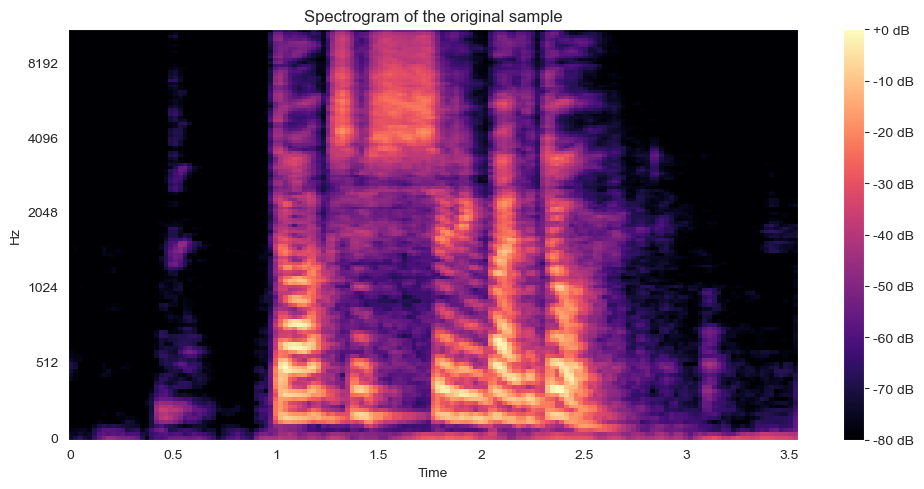

In [219]:
# spectrogram of the original sample
sample, sr = get_sample(file_name)
print(file_name)
spectrogram = get_spectrogram(sample, sr)
plt.figure(figsize=(10, 5))
sns.set_style('darkgrid')
librosa.display.specshow(spectrogram, y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram of the original sample')
plt.tight_layout()
plt.show()

data\Fearful\03-01-06-01-02-02-19.wav


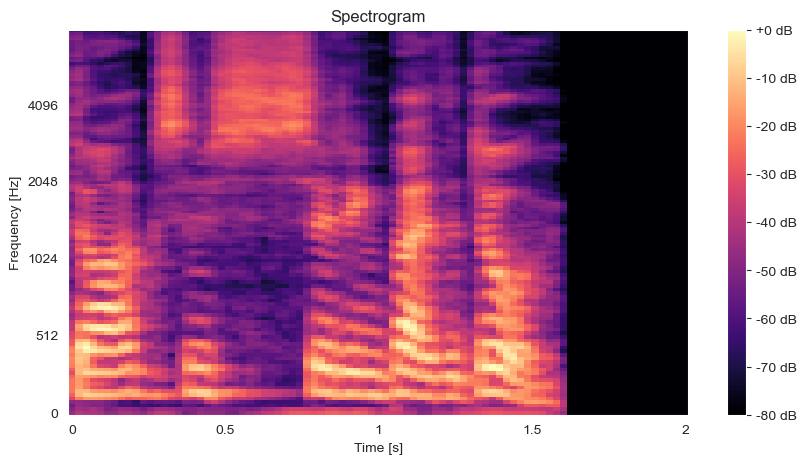

In [220]:
# test the functions
sample, sr = preprocess_data(file_name)
print(file_name)
spectrogram = get_spectrogram(sample, sr)

# plot spectrogram
plt.figure(figsize=(10, 5))
sns.set_style('darkgrid')
librosa.display.specshow(spectrogram, x_axis='time', y_axis='mel', sr=sr, fmax=8000, cmap= 'magma')
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.show()

### Create the train and validation sets

In [221]:
# create a subdirectory for training and validation datasets with each emotion
for emotion in class_names:
    if not os.path.exists(os.path.join('data', 'train', emotion)):
        os.makedirs(os.path.join('data', 'Train', emotion), exist_ok=True)
    if not os.path.exists(os.path.join('data', 'val', emotion)):
        os.makedirs(os.path.join('data', 'Validation', emotion), exist_ok=True)

In [222]:
import glob
# get the dictionary of the files path for each emotion in data directory
files_dict = {}
for emotion in class_names:
    files_dict[emotion] = glob.glob(os.path.join('data', emotion, '*.wav'))

In [223]:
VALIDATION_SPLIT = 0.2

for emotion in class_names:
    # get the list of the files path for each emotion
    files = files_dict[emotion]
    # get the number of the files to be used for validation dataset
    num_val = int(len(files) * VALIDATION_SPLIT)
    # get the list of the files to be used for validation dataset
    files_val = random.sample(files, num_val)
    # move the files to the corresponding subdirectory
    for file in files_val:
        file_name = os.path.basename(file)
        shutil.move(file, os.path.join('data', 'Validation', emotion, file_name))

In [224]:
# move all the remaining files to the corresponding subdirectory in training dataset
for emotion in class_names:
    emotion_dir = os.path.join('data', emotion)
    files = glob.glob(os.path.join(emotion_dir, '*.wav'))
    for file in files:
        file_name = os.path.basename(file)
        shutil.move(file, os.path.join('data', 'Train', emotion, file_name))

In [225]:
# delete the empty directories whose names are emotion names
for emotion in class_names:
    shutil.rmtree(os.path.join('data', emotion))

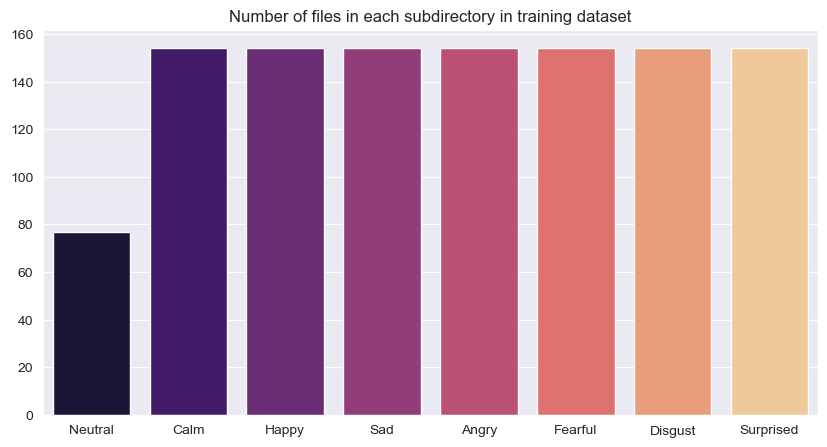

In [226]:
# barplot of the number of files in each subdirectory in training dataset
num_files = []
for emotion in class_names:
    num_files.append(len(os.listdir(os.path.join('data', 'Train', emotion))))

plt.figure(figsize=(10, 5))
sns.barplot(x=class_names, y=num_files, palette='magma')
plt.title('Number of files in each subdirectory in training dataset')
plt.show()

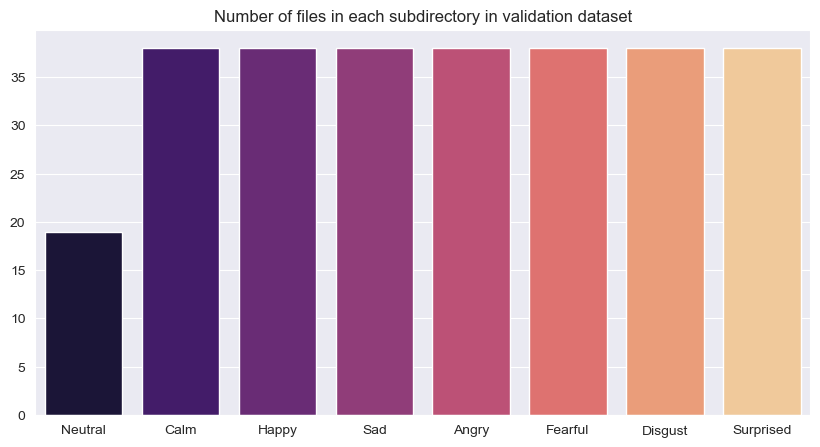

In [227]:
# barplot of the number of files in each subdirectory in validation dataset
num_files = []
for emotion in class_names:
    num_files.append(len(os.listdir(os.path.join('data', 'Validation', emotion))))

plt.figure(figsize=(10, 5))
sns.barplot(x=class_names, y=num_files, palette='magma')
plt.title('Number of files in each subdirectory in validation dataset')
plt.show()

In [228]:
# function to get spectogram of each file for validation dataset (without augmentation)
def get_spectrogram_val(file_path):
    # get the preprocessed data of the file with use of previously defined function
    sample, sr = preprocess_data(file_path)
    # get the spectrogram of the file with use of previously defined function
    spectrogram = get_spectrogram(sample, sr)
    # get the name of the file
    label = extract_info(file_path).capitalize()
    file_name = file_path.split('\\')[-1]
    name = file_name.replace('.wav', '.png')
    path = os.path.join('data\Validation', label, name)
    fig = plt.figure(figsize=(1, 1))
    librosa.display.specshow(data=spectrogram, sr=sr, cmap='magma')
    plt.axis('off')
    fig.savefig(path, bbox_inches='tight', pad_inches=0)
    plt.close(fig)

In [229]:
# generate the spectrograms for each file in validation dataset and save them to the corresponding subdirectory
for emotion in class_names:
    emotion_dir = os.path.join('data', 'Validation', emotion)
    files = glob.glob(os.path.join(emotion_dir, '*.wav'))
    for file in files:
        get_spectrogram_val(file)
        # delete the .wav file
        os.remove(file)

In [230]:
# function to get spectogram of each file for training dataset (with augmentation)
def get_spectrogram_train(file_path):
    # get the preprocessed data of the file with use of previously defined function
    sample, sr = preprocess_data(file)
    # data augmentation
    sample_noise, sr = add_noise(sample, sr)
    sample_pitch, sr = pitch_shift(sample, sr)
    sample_time, sr = time_stretch(sample, sr)
    # get the spectrograms
    spectrogram = get_spectrogram(sample, sr)
    spectrogram_noise = get_spectrogram(sample_noise, sr)
    spectrogram_pitch = get_spectrogram(sample_pitch, sr)
    spectrogram_time = get_spectrogram(sample_time, sr)
    
    spectograms = [spectrogram, spectrogram_noise, spectrogram_pitch, spectrogram_time]
    label = extract_info(file_path).capitalize()
    file_name = file.split('\\')[-1]

    # save the data to the directory
    for i, spec in enumerate(spectograms):
        name = file_name.replace('.wav', f'-{i}.png')
        path = os.path.join('data\Train', label, name)

        fig = plt.figure(figsize=(1, 1))
        librosa.display.specshow(data=spec, sr=sr, cmap='magma')
        plt.axis('off')
        fig.savefig(path, bbox_inches='tight', pad_inches=0)
        plt.close(fig)

In [231]:
# generate the spectrograms for each file in training dataset and save them to the corresponding subdirectory
for emotion in class_names:
    emotion_dir = os.path.join('data', 'Train', emotion)
    files = glob.glob(os.path.join(emotion_dir, '*.wav'))
    for file in files:
        get_spectrogram_train(file)
        # delete the .wav file
        os.remove(file)

#### Load the training and validation data using the image_dataset_from_directory function from Keras

In [232]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [233]:
BATCH_SIZE = 32

IMAGE_HEIGHT = 77
IMAGE_WIDTH = 77

train_ds = image_dataset_from_directory(
    'data\Train',
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    shuffle=True,
    seed=42,
    labels='inferred',
    label_mode='categorical'
)

val_ds = image_dataset_from_directory(
    'data\Validation',
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    shuffle=False,
    labels='inferred',
    label_mode='categorical'
)

Found 4620 files belonging to 8 classes.
Found 285 files belonging to 8 classes.


In [234]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# function to plot the history of the model training process (accuracy and loss)
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    sns.set_style('darkgrid')
    sns.lineplot(x=history.epoch, y=history.history['acc'], ax=ax1, label='Training Accuracy', marker='o', color='blue', linestyle='dashed')
    sns.lineplot(x=history.epoch, y=history.history['val_acc'], ax=ax1, label='Validation Accuracy', marker='o', color='orange', linestyle='dashed')
    sns.lineplot(x=history.epoch, y=history.history['loss'], ax=ax2, label='Training Loss', marker='o', color='blue', linestyle='dashed')
    sns.lineplot(x=history.epoch, y=history.history['val_loss'], ax=ax2, label='Validation Loss', marker='o', color='orange', linestyle='dashed')
    ax1.set_title('Training and Validation Accuracy')
    ax2.set_title('Training and Validation Loss')
    plt.show()

# function to plot the confusion matrix and print the classification report
def evaluate_model(y_pred, y_test):
    # plot the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    # change the labels to the actual names
    labels = ['Angry', 'Calm', 'Disgust', 'Fearful', 'Happy', 'Neutral', 'Sad', 'Surprised']
    plt.xticks(np.arange(8) + 0.5, labels)
    plt.yticks(np.arange(8) + 0.5, labels)
    plt.show()

    # print classification report
    print(classification_report(y_test, y_pred))

#### Define the model, compile and train it

In [249]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Flatten()) # flatten the output of the convolutional layers to feed it to the dense layers
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(8, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer = 'adam',
              metrics=['acc'])

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_61 (Conv2D)          (None, 77, 77, 32)        896       
                                                                 
 max_pooling2d_61 (MaxPoolin  (None, 38, 38, 32)       0         
 g2D)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 38, 38, 32)        0         
                                                                 
 conv2d_62 (Conv2D)          (None, 38, 38, 64)        18496     
                                                                 
 max_pooling2d_62 (MaxPoolin  (None, 19, 19, 64)       0         
 g2D)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 19, 19, 64)      

Epoch 1/50
145/145 [==============================] - 36s 242ms/step - loss: 5.0293 - acc: 0.1619 - val_loss: 2.0151 - val_acc: 0.2175
Epoch 2/50
145/145 [==============================] - 32s 219ms/step - loss: 1.9921 - acc: 0.2082 - val_loss: 1.9406 - val_acc: 0.2632
Epoch 3/50
145/145 [==============================] - 32s 222ms/step - loss: 1.8344 - acc: 0.2898 - val_loss: 1.7534 - val_acc: 0.3684
Epoch 4/50
145/145 [==============================] - 32s 221ms/step - loss: 1.7352 - acc: 0.3429 - val_loss: 1.6803 - val_acc: 0.3860
Epoch 5/50
145/145 [==============================] - 32s 219ms/step - loss: 1.6331 - acc: 0.3842 - val_loss: 1.5991 - val_acc: 0.4246
Epoch 6/50
145/145 [==============================] - 33s 223ms/step - loss: 1.5228 - acc: 0.4286 - val_loss: 1.4509 - val_acc: 0.4140
Epoch 7/50
145/145 [==============================] - 34s 230ms/step - loss: 1.4299 - acc: 0.4669 - val_loss: 1.3578 - val_acc: 0.4982
Epoch 8/50
145/145 [==============================] - 3

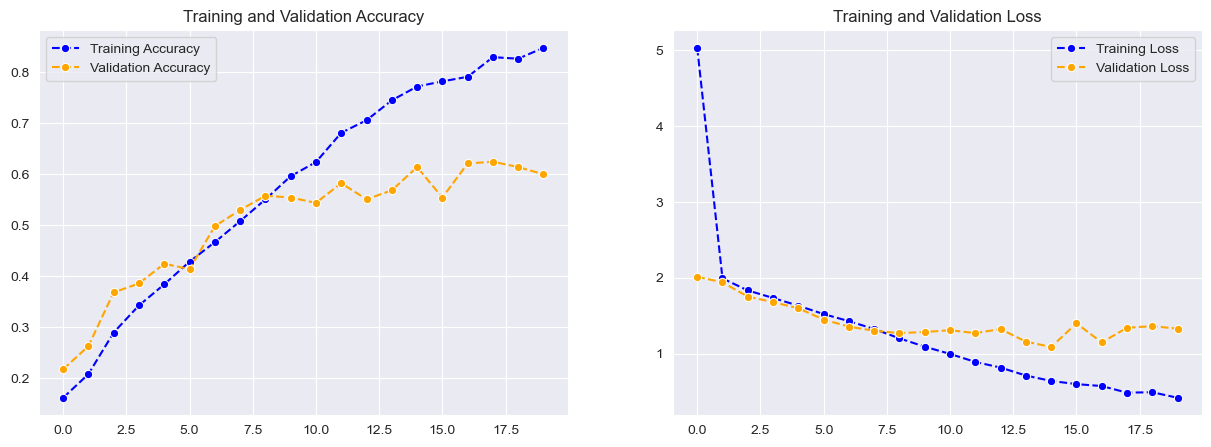

In [250]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(train_ds,
                    epochs=50,
                    validation_data=val_ds,
                    callbacks=[early_stopping])

plot_history(history)

In [ ]:
# save the model
model.save('model.h5')

9/9 [==============================] - 1s 54ms/step


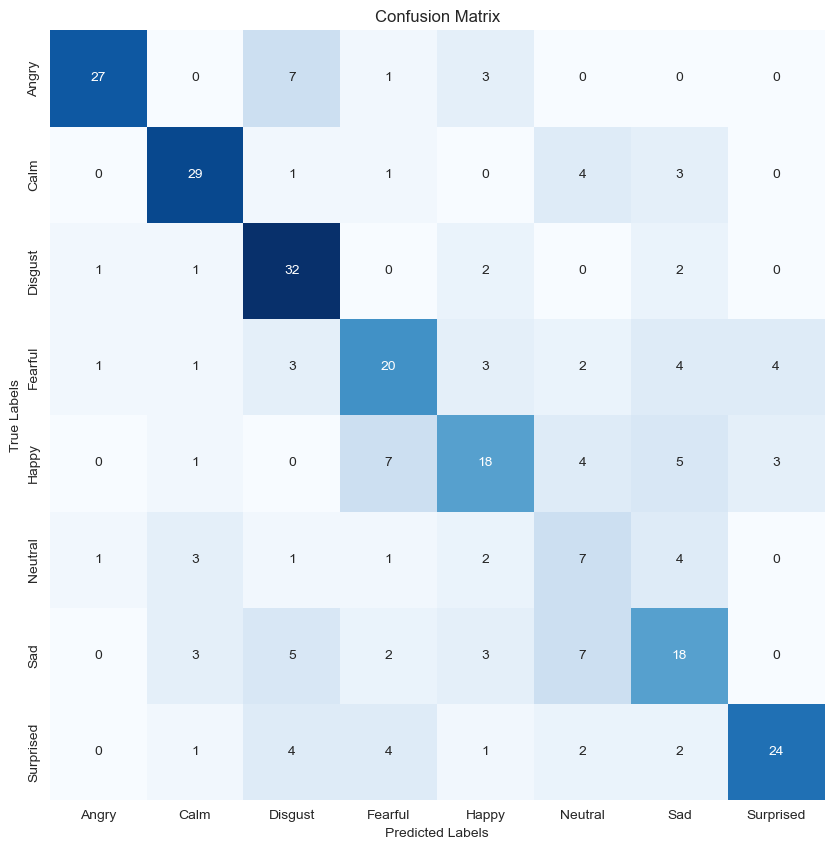

              precision    recall  f1-score   support

           0       0.90      0.71      0.79        38
           1       0.74      0.76      0.75        38
           2       0.60      0.84      0.70        38
           3       0.56      0.53      0.54        38
           4       0.56      0.47      0.51        38
           5       0.27      0.37      0.31        19
           6       0.47      0.47      0.47        38
           7       0.77      0.63      0.70        38

    accuracy                           0.61       285
   macro avg       0.61      0.60      0.60       285
weighted avg       0.63      0.61      0.62       285



In [251]:
# evaluate the model on the validation dataset
y_pred = model.predict(val_ds)
y_pred = np.argmax(y_pred, axis=1)

y_test = []
for images, labels in val_ds:
    y_test.extend(np.argmax(labels.numpy(), axis=1))

evaluate_model(y_pred, y_test)

## Spectogram augmentation with SpecAugment

The SpecAugment algorithm is a simple and effective method for augmenting spectrograms. It was proposed by Daniel S. Park, William Chan, Yu Zhang, Chung-Cheng Chiu, Barret Zoph, Ekin D. Cubuk, Quoc V. Le in their paper [SpecAugment: A Simple Data Augmentation Method for Automatic Speech Recognition](https://arxiv.org/abs/1904.08779).

The below algorithm was implemented by Kaggle user [DavidS](https://www.kaggle.com/davids1992) in his notebook [SpecAugment quick implementation](https://www.kaggle.com/code/davids1992/specaugment-quick-implementation).

In [47]:
# spectrogram augmentation with SpecAugment
def spec_augment(spec: np.ndarray, num_mask=2, freq_masking_max_percentage=0.15, time_masking_max_percentage=0.3)->np.ndarray:
    spec = spec.copy()
    for i in range(num_mask):
        all_frames_num, all_freqs_num = spec.shape
        freq_percentage = random.uniform(0.0, freq_masking_max_percentage)

        num_freqs_to_mask = int(freq_percentage*all_freqs_num)
        f0 = np.random.uniform(low=0.0, high=all_freqs_num - num_freqs_to_mask)
        f0 = int(f0)
        spec[:, f0:f0 + num_freqs_to_mask] = 0

        time_percentage = random.uniform(0.0, time_masking_max_percentage)

        num_frames_to_mask = int(time_percentage*all_frames_num)
        t0 = np.random.uniform(low=0.0, high=all_frames_num - num_frames_to_mask)
        t0 = int(t0)
        spec[t0:t0 + num_frames_to_mask, :] = 0
    return spec

#### Example of augmented spectrograms

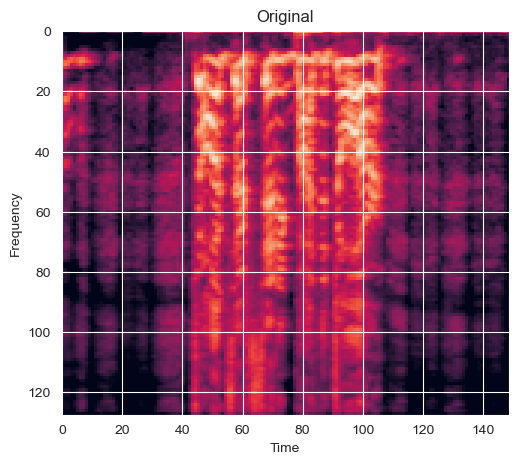

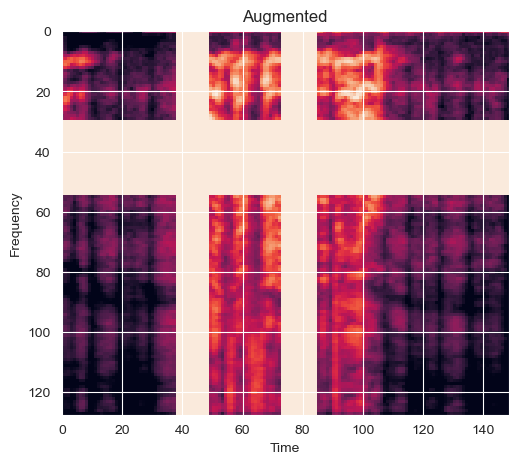

In [48]:
# plot the augmented spectrogram
file_name = random.choice(files)
sample, sr = get_sample(file_name)
spectrogram = librosa.feature.melspectrogram(y=sample, sr=sr)
# to decibel
spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
augmented_spectrogram = spec_augment(spectrogram)
plt.figure(figsize=(10, 5))
sns.set_style('darkgrid')
plt.imshow(spectrogram)
plt.title('Original')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()
plt.figure(figsize=(10, 5))
sns.set_style('darkgrid')
plt.imshow(augmented_spectrogram)
plt.title('Augmented')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()